# Audio Match Sonification
Load an audio file, extract the key. Load an image, convert to audio with a musical inverse spectrogram technique (using additive synthesis). Use the audio key to set the frequencies of the image sonification so that it can be combined with the original audio. 

Using major or minor pentatonic will help reduce dissonance in general. It also helps when the key finder is wrong by a perfect 4th or 5th, which is probably the most common error. 

TO DO: 
- build in tempo, key signature finder
- write better algorithm for mixing the signals (for the actual app, they shoudl be able to adjust the mix in real time and do volume automation, then it would get bounced down to a single file when they export)

In [12]:
from subroutines import *

## Convert mp3 to wave (needed later)

In [23]:
from os import path
from pydub import AudioSegment

# audio_filename='electric-feel' #should be G# major, 103bpm, 6/4
# tempo = 103 
# beats_per_bar = 6 

audio_filename='sweet-home-alabama' #should be G major, 98bpm, 4/4
tempo = 98 
beats_per_bar = 4

audio_path_mp3 = './audio/' +audio_filename+'.mp3' #short sample
audio_path_wav = './audio/' +audio_filename+'.wav' #short sample

# convert wav to mp3                                                            
sound = AudioSegment.from_mp3(audio_path_mp3)
sound.export(audio_path_wav, format="wav")

#wav to mp3: 
#AudioSegment.from_wav("/input/file.wav").export("/output/file.mp3", format="mp3")



<_io.BufferedRandom name='./audio/electric-feel.wav'>

## Extract Key
From: https://github.com/jackmcarthur/musical-key-finder 

In [24]:
import librosa


# the load function generates a tuple consisting of an audio object y and its sampling rate sr
y, sr = librosa.load(audio_path_mp3)

# this function filters out the harmonic part of the sound file from the percussive part, allowing for
# more accurate harmonic analysis
y_harmonic, y_percussive = librosa.effects.hpss(y)


/Users/mattrusso/opt/miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [25]:
tonal_frag = Tonal_Fragment(y_harmonic, sr, tend=22)
# tonal_frag.print_chroma()
# chroma = tonal_frag.get_chroma()
tonal_frag.print_key()

key = tonal_frag.get_key()
key_letter = key[:2].strip() #should find better way!
key_harmony = key[2:].strip()

likely key: G# major, correlation: 0.812


## Generate note frequencies from the extracted key

In [26]:
start_octave = 3 #keep it kind of high to not clash as much
n_octaves = 4

pentOn = True #use pentatonic for a less dissonant result

if pentOn:
    scale = key_harmony +'Pent'
else: 
    scale = key_harmony
freqs = get_scale_freqs(start_note=key_letter + str(start_octave), octaves=n_octaves, scale=scale)

print(freqs)

[207.65234878997256, 233.08188075904496, 261.6255653005986, 311.1269837220809, 349.2282314330039, 415.3046975799451, 466.1637615180899, 523.2511306011972, 622.2539674441618, 698.4564628660078, 830.6093951598903, 932.3275230361799, 1046.5022612023945, 1244.5079348883237, 1396.9129257320155, 1661.2187903197805, 1864.6550460723593, 2093.004522404789, 2489.0158697766474, 2793.825851464031, 3322.437580639561]


## Load image 
Reduce vertical resolution to number of notes

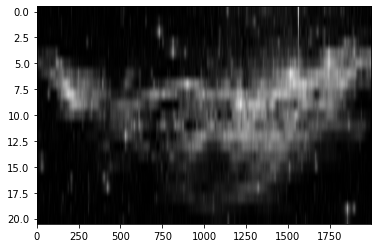

In [27]:
from PIL import Image

image_filename = 'carina_nircam_g' #name of jpg file
image_path = './images/'+image_filename+'.jpg'

img = Image.open(image_path) 
img = boost_contrast(img) #makes structure easier to hear

imgR = img.resize(size = (img.width,len(freqs)), resample=Image.LANCZOS) 
pixels = np.array(imgR.convert('L'))/255 #normalize

plt.imshow(pixels,aspect='auto',cmap='gray')

## Sonify

In [28]:

fs = read_wave(audio_path_wav).framerate #sample rate (needs to match song sample rate)


time_per_bar = beats_per_bar*60/tempo
n_bars = 4
duration = n_bars*time_per_bar #seconds, need to set with tempo, key signature and # of bars

print(round(duration,2),'seconds')

wave_sonif = additive_synth(pixels, freqs, fs, duration)
wave_sonif.make_audio()

9.8 seconds


(207.65234878997256, 3322.437580639561)

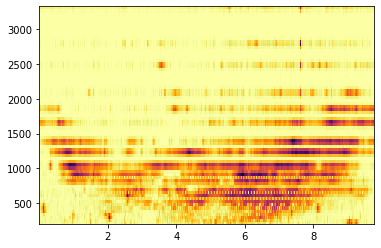

In [29]:
spec = wave_sonif.make_spectrogram(seg_length=1000)
spec.plot()
plt.ylim(min(freqs),max(freqs))

## Combine (poorly) with orignial song to test harmony
Just copying sonification as many times as it will fit cleanly

In [30]:
wave_song = read_wave(audio_path_wav)

mix = 0.15 #0 to 1 

wave_mix = wave_song.copy()
n_samp = 0
n_sonf_samp = len(wave_sonif.ts)
while n_samp<len(wave_song.ts)- n_sonf_samp:
    wave_mix.ys[n_samp:n_samp + n_sonf_samp] = (1 - mix)*wave_song.ys[n_samp:n_samp + n_sonf_samp] + mix*wave_sonif.ys
    n_samp += len(wave_sonif.ts)
wave_mix.make_audio()

(195.99771799087466, 3135.9634878539937)

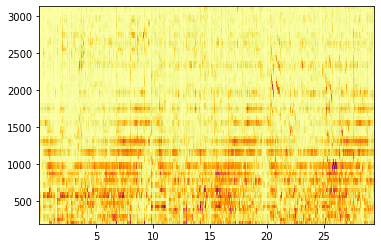

In [21]:
spec = wave_mix.make_spectrogram(seg_length=1000)
spec.plot()
plt.ylim(min(freqs),max(freqs))

## Save mix

In [22]:
wave_mix.normalize(0.9)
wave_mix.write('./mixes/' + audio_filename + '_' +image_filename + '.wav')

Writing ./mixes/sweet-home-alabama_carina_nircam_g.wav
